In [2]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    classification_report
)
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier


In [4]:
df = pd.read_csv("/Users/satviksingh/Documents/manas_projects/tree/yeast.csv")

X = df.drop(columns=['name'])
y = df['name']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("dataset loaded ")

dataset loaded 


In [5]:
depths = range(1, 50)
accuracy_scores = []

for d in depths:
    model = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=d,
        min_samples_split=10,
        random_state=42
    )
    acc = cross_val_score(model, X, y_encoded, cv=skf, scoring='accuracy').mean()
    accuracy_scores.append(acc)

best_depth = depths[np.argmax(accuracy_scores)]
print(f"Best depth: {best_depth}")


Best depth: 6


In [6]:
def evaluate_model(model, X, y, skf):
    acc = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()
    f1  = cross_val_score(model, X, y, cv=skf, scoring='f1_macro').mean()

    mcc_scores = []
    for train_idx, test_idx in skf.split(X, y):
        model.fit(X.iloc[train_idx], y[train_idx])
        preds = model.predict(X.iloc[test_idx])
        mcc_scores.append(matthews_corrcoef(y[test_idx], preds))

    return acc, f1, np.mean(mcc_scores)


In [7]:
dt_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=best_depth,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)

baseline_accuracy, baseline_f1, baseline_mcc = evaluate_model(
    dt_model, X, y_encoded, skf
)

print("\n--- Decision Tree ---")
print(baseline_accuracy, baseline_f1, baseline_mcc)



--- Decision Tree ---
0.522959322959323 0.5016576350854242 0.40766519912212235


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

dt_model.fit(X_train, y_train)
preds = dt_model.predict(X_test)

labels = np.unique(np.concatenate([y_test, preds]))
target_names = le.inverse_transform(labels)

print(classification_report(
    y_test, preds,
    labels=labels,
    target_names=target_names,
    zero_division=0
))


              precision    recall  f1-score   support

         CYT       0.50      0.45      0.47        93
         ERL       1.00      1.00      1.00         1
         EXC       0.43      0.43      0.43         7
         ME1       0.82      1.00      0.90         9
         ME2       0.21      0.30      0.25        10
         ME3       0.60      0.84      0.70        32
         MIT       0.44      0.57      0.50        49
         NUC       0.50      0.37      0.43        86
         POX       0.50      0.25      0.33         4
         VAC       0.00      0.00      0.00         6

    accuracy                           0.49       297
   macro avg       0.50      0.52      0.50       297
weighted avg       0.49      0.49      0.48       297



In [9]:
bootstrap_true, bootstrap_pred = [], []

for train_idx, test_idx in skf.split(X, y_encoded):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    boot_idx = np.random.choice(len(X_train), len(X_train), replace=True)
    X_boot = X_train.iloc[boot_idx]
    y_boot = y_train[boot_idx]

    tree = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=best_depth,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    )

    tree.fit(X_boot, y_boot)
    preds = tree.predict(X_test)

    bootstrap_true.extend(y_test)
    bootstrap_pred.extend(preds)

bootstrap_accuracy = accuracy_score(bootstrap_true, bootstrap_pred)
bootstrap_f1 = f1_score(bootstrap_true, bootstrap_pred, average='macro')
bootstrap_mcc = matthews_corrcoef(bootstrap_true, bootstrap_pred)


In [10]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        criterion='entropy',
        max_depth=best_depth,
        min_samples_split=10,
        class_weight='balanced'
    ),
    n_estimators=50,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

bagging_accuracy, bagging_f1, bagging_mcc = evaluate_model(
    bagging_model, X, y_encoded, skf
)


In [11]:
boosting_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        criterion='entropy',
        max_depth=2,
        min_samples_split=10
    ),
    n_estimators=50,
    learning_rate=0.5,
    random_state=42
)

boosting_accuracy, boosting_f1, boosting_mcc = evaluate_model(
    boosting_model, X, y_encoded, skf
)


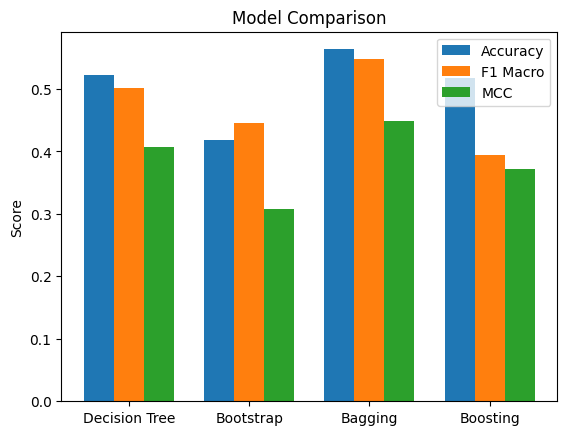

In [12]:
methods = ['Decision Tree', 'Bootstrap', 'Bagging', 'Boosting']

accuracy_vals = [
    baseline_accuracy,
    bootstrap_accuracy,
    bagging_accuracy,
    boosting_accuracy
]

f1_vals = [
    baseline_f1,
    bootstrap_f1,
    bagging_f1,
    boosting_f1
]

mcc_vals = [
    baseline_mcc,
    bootstrap_mcc,
    bagging_mcc,
    boosting_mcc
]

x = np.arange(len(methods))
width = 0.25

plt.figure()
plt.bar(x - width, accuracy_vals, width, label='Accuracy')
plt.bar(x, f1_vals, width, label='F1 Macro')
plt.bar(x + width, mcc_vals, width, label='MCC')

plt.xticks(x, methods)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()
plt.show()


Conclusion

The dataset is imbalanced, so accuracy alone is not sufficient.
A single Decision Tree tends to overfit and mainly favors majority classes.
Bootstrapping slightly improves stability but gives limited gains.
Bagging reduces variance by averaging multiple trees, improving overall performance.
Boosting performs best by focusing on difficult samples and correcting errors iteratively.

Hence, ensemble methods outperform a single Decision Tree on this dataset.